In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import ripser
import persim

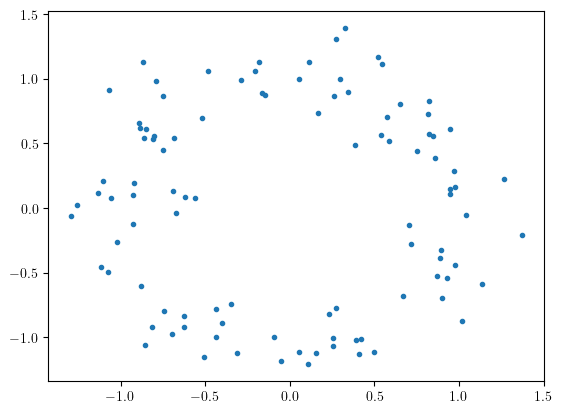

In [4]:
# reading the circle
X = np.loadtxt("../R/unitCircle.csv", skiprows=1, delimiter=",")
plt.plot(X[:,0], X[:,1], ".")

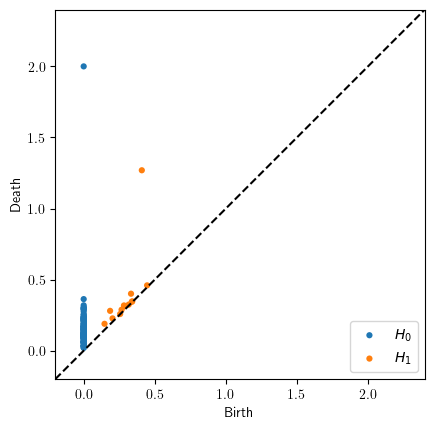

In [5]:
D = ripser.ripser(X, thresh=2)["dgms"]
D[0][-1, 1] = 2
persim.plot_diagrams(D)

In [35]:
def DiagToPD(D):
    PD = [ np.array([D[dim][:,0], D[dim][:,1] - D[dim][:,0]]) for dim in range(len(D))]
    return PD
PD = DiagToPD(D)

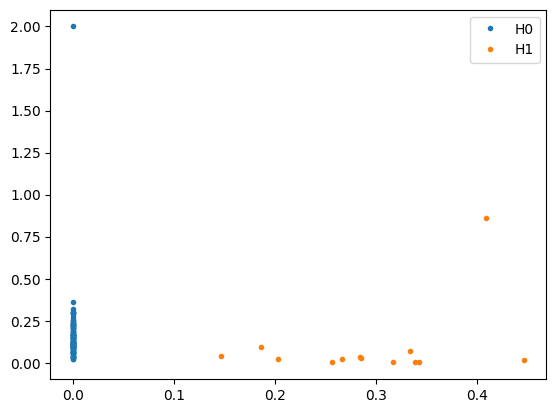

In [36]:
PD = DiagToPD(D)
for dim in range(len(PD)):
    pd_ = PD[dim]
    plt.plot(pd_[0], pd_[1], ".", label = "H"+str(dim))
plt.legend()

In [37]:
# Compare with R results
pd_R = pd.read_csv("../R/PD.csv")
for dim in range(len(PD)):
    print("dim=", dim)
    for i_var, var in enumerate(["Birth", "Persistence"]):
        perPy = np.sort(PD[dim][i_var])
        perR =  np.sort(pd_R[pd_R["dimension"]==dim][var].sort_values().to_numpy())
        diff = perPy - perR
        diff = diff[:-1]
        print("\t", var, ": ", max(abs(diff)))


dim= 0
	 Birth :  0.0
	 Persistence :  1.2275210570233952e-08
dim= 1
	 Birth :  1.4883316690195159e-08
	 Persistence :  2.435955601121087e-08


In [38]:
ySeqH0 = [0.02041084, 0.08344844, 0.11463878, 0.15101483, 0.21628494, 2.00000000]
diff = np.quantile(PD[0][1], np.arange(0, 1.1, 0.2)) - ySeqH0
print("y H0: ", sum(abs(diff)))
#
xSeqH1 = [0.1465692, 0.2243164, 0.2800285, 0.3200161, 0.3404307, 0.4460450]
diff = np.quantile(PD[1][0], np.arange(0, 1.1, 0.2)) - xSeqH1
print("x H1: ", sum(abs(diff)))
#
ySeqH1 = [0.001683940, 0.006422564, 0.020160192, 0.028070682, 0.057836529, 0.860326686]
diff = np.quantile(PD[1][1], np.arange(0, 1.1, 0.2)) - ySeqH1
print("y H1: ", sum(abs(diff)))


y H0:  1.4247217156038161e-08
x H1:  1.6027660373896246e-07
y H1:  8.299978638149491e-08


In [85]:
def computeVPB_dim0(x, y, ySeq, lam):
    dy = np.diff(ySeq)
    vpb = np.zeros( len(dy))
    for i in range(len(dy)):
        c = ySeq[i]
        d = ySeq[i+1]
        for j in range( len(y)):
            if c - lam[j] < y[j] and y[j] < d + lam[j]:
                y_cd = y[j]
                lam_cd = lam[j]
                yMin = max(c, y_cd - lam_cd)
                yMax = min(d, y_cd + lam_cd)
                vpb[i] += 0.5*(yMax**2 - yMin**2)/dy[i]
    return vpb

def pmax(num, vec):
    return np.array([max(num, vec[i_]) for i_ in range(vec.size)])
def pmin(num, vec):
    return np.array([min(num, vec[i_]) for i_ in range(vec.size)])

def computeVPB_dim1(x, y, xSeq, ySeq, lam):
    dx = np.diff(xSeq)
    dy = np.diff(ySeq)
    vpb = np.zeros( (dx.size, dy.size) )
    for i in range(dx.size):
        a, b = xSeq[i], xSeq[i+1]
        for j in range(dy.size):
            c, d = ySeq[j], ySeq[j+1]
            xCond = (x+lam >= a) & (x-lam <= b)
            yCond = (y+lam >= c) & (y-lam <= d)
            inds = np.where(xCond & yCond)[0]
            if len(inds)>0:
                xInd, yInd, lamInd = x.take(inds), y.take(inds), lam.take(inds)
                xMin, xMax = pmax(a, xInd - lamInd), pmin(b, xInd + lamInd)
                yMin, yMax = pmax(c, yInd - lamInd), pmin(d, yInd + lamInd)
                add = 0.5*np.sum( (xMax-xMin)*(yMax-yMin)*(xMax+xMin+yMax+yMin))/dx[i]/dy[j]
                vpb[i, j] += add
    return vpb

def computeVPB(PD, homDim, xSeq, ySeq, tau=0.3):
    x = PD[homDim][0]
    y = PD[homDim][1]
    lam = tau * y
    if homDim == 0:
        return computeVPB_dim0(x, y, ySeq, lam)
    else:
        return computeVPB_dim1(x, y, xSeq, ySeq, lam)


vpb0 = computeVPB(PD, homDim=0, xSeq=[], ySeq=ySeqH0)
vpb1 = computeVPB(PD, homDim = 1, xSeq=xSeqH1, ySeq=ySeqH1)

In [86]:
print(max(abs(vpb0 - [0.809001, 3.644815, 5.486612, 6.382816, 1.013953])))

5.058106129496309e-07


In [87]:
vpb_ = np.transpose(vpb1).reshape( (25,))
max(abs(
    vpb_ - 
    [ 0.0000000000, 0.0004995598, 0.0090337733, 0.0305098818, 0.0057973687, 0.0095194496, 0.0261053157, 0.0203673036, 0.0042870130,
        0.0107446149, 0.0425768331, 0.1053468321, 0.1458807241, 0.0000000000, 0.0000000000, 0.0328035481, 0.0276785592, 0.1089088594,
        0.1318822254, 0.0168304895, 0.2939394561, 0.3162986126, 0.3344510989, 0.3567486932, 0.3636226941]
))

2.996362796180152e-07

In [90]:
D[0]

array([[0.        , 0.02041084],
       [0.        , 0.02051534],
       [0.        , 0.03163802],
       [0.        , 0.03196964],
       [0.        , 0.03310784],
       [0.        , 0.03541122],
       [0.        , 0.03557534],
       [0.        , 0.03896011],
       [0.        , 0.05202492],
       [0.        , 0.05476255],
       [0.        , 0.05700218],
       [0.        , 0.05853151],
       [0.        , 0.06107267],
       [0.        , 0.06140893],
       [0.        , 0.06226637],
       [0.        , 0.06261025],
       [0.        , 0.06646532],
       [0.        , 0.06915883],
       [0.        , 0.07649768],
       [0.        , 0.08323621],
       [0.        , 0.0835015 ],
       [0.        , 0.0880843 ],
       [0.        , 0.08917707],
       [0.        , 0.08960409],
       [0.        , 0.09161533],
       [0.        , 0.09391432],
       [0.        , 0.09477938],
       [0.        , 0.09636623],
       [0.        , 0.10084815],
       [0.        , 0.10086332],
       [0.

In [88]:
def computePL(D, homDim, scaleSeq, k=1):
    x = D[homDim][:,0]
    y = D[homDim][:,1]
    lambda = np.zeros( )